## Spark Initializing

In [2]:
import findspark
findspark.init()
import pyspark
import pandas as pd
import seaborn as sns # To get graphs
import matplotlib.pyplot as plt # To get graphs

In [3]:
#### First we have create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .appName('Forcast') \
                    .getOrCreate()

In [4]:
spark

### Importing DataSet

In [5]:
#df = spark.read.option("header" , True).csv("D:\\Vizuamatix exam\\final_dispatch.csv")
df = spark.read.option("header" , True).csv("/Users/Asus/Documents/InternCsv/combine_final.csv")

In [6]:
df.show()

+-------------+--------+----+---------------+-------------------+----------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|
+-------------+--------+----+---------------+-------------------+----------+
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|
|     KPS(GT7)|7/1/2020|0:00|              0|                  0|         0|
|         Polp|7/1/2020|0:00|             40|                 78|       -38|
|          WPS|7/1/2020|0:00|              0|                  0|         0|
|         Rand|7/1/2020|0:00|              0|                  0|         0|
|VPOWER Horona|7/1/2020|0:00|              0|                  0|         0|
|       LVPS 2|7/1/2020|0:00|            540|                270|       270|
|          Uku|7/1/2020|0:00|             72|                 40|        32|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|

In [8]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
df_dev = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date","Time","Plant")))

In [9]:
train_df = df_dev.where("rank <= .8").drop("rank")
train_df.show()

+-------------+--------+----+---------------+-------------------+----------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|
+-------------+--------+----+---------------+-------------------+----------+
|     ACE EMBP|7/1/2020|0:00|              0|                 51|       -51|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|
|ALTAQQA-Mahi.|7/1/2020|0:00|              0|                  0|         0|
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|
|   Asia Power|7/1/2020|0:00|              0|                 33|       -33|
|        Barge|7/1/2020|0:00|             90|                 45|        45|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|
|CEB Sup Power|7/1/2020|0:00|              0|                  0|         0|
|       Canyon|7/1/2020|0:00|             20|                  0|        20|
|         KCCP|7/1/2020|0:00|              0|                  0|         0|

In [10]:
train_df = train_df.withColumn("Difference",train_df.Difference.cast('double'))

In [11]:
train_df = train_df.withColumn("Actual_Dispatch",train_df.Actual_Dispatch.cast('double'))

In [12]:
train_df = train_df.withColumn("Forecasted_Dispatch",train_df.Forecasted_Dispatch.cast('double'))

In [13]:
train_df.dtypes


[('Plant', 'string'),
 ('Date', 'string'),
 ('Time', 'string'),
 ('Actual_Dispatch', 'double'),
 ('Forecasted_Dispatch', 'double'),
 ('Difference', 'double')]

## 1) Actual Dispatches Daily

In [16]:
from pyspark.sql.functions import col
sumtot = train_df.groupBy("Date").sum("Actual_Dispatch","Forecasted_Dispatch","Difference").sort(col("Date").asc())

In [17]:
sumtot.show(10)

+---------+--------------------+------------------------+---------------+
|     Date|sum(Actual_Dispatch)|sum(Forecasted_Dispatch)|sum(Difference)|
+---------+--------------------+------------------------+---------------+
| 7/1/2020|            164394.0|                 86666.0|        77728.0|
|7/10/2020|            168756.0|                 84202.0|        84554.0|
|7/11/2020|            150952.0|                 80095.0|        70857.0|
|7/12/2020|            133281.0|                 69588.0|        63693.0|
|7/13/2020|            163359.0|                 82308.0|        81051.0|
|7/14/2020|            173932.0|                 87793.0|        86139.0|
|7/15/2020|            171561.0|                 87663.0|        83898.0|
|7/16/2020|            165218.0|                 85969.0|        79249.0|
|7/17/2020|            165218.0|                 82911.0|        82307.0|
|7/18/2020|            159815.0|                 82847.0|        76968.0|
+---------+--------------------+------

In [19]:
df1 = sumtot.toPandas()
df1.head()

,Date,sum(Actual_Dispatch),sum(Forecasted_Dispatch),sum(Difference)
0,7/1/2020,164394.0,86666.0,77728.0
1,7/10/2020,168756.0,84202.0,84554.0
2,7/11/2020,150952.0,80095.0,70857.0
3,7/12/2020,133281.0,69588.0,63693.0
4,7/13/2020,163359.0,82308.0,81051.0


### Finding Correlations in between df1 dataFrame

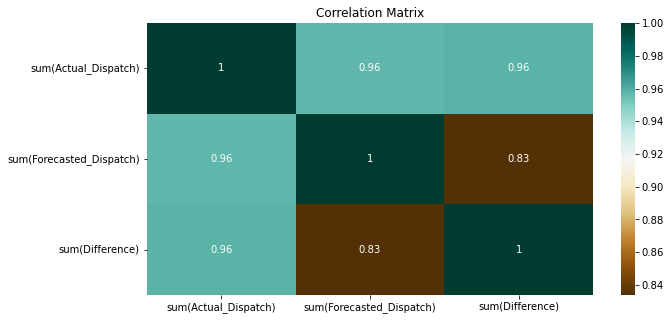

In [20]:
# Correlation Heatmap
plt.figure(figsize = (10, 5))
c = df1.corr()
sns.heatmap(c, cmap = "BrBG", annot = True)
plt.title("Correlation Matrix")
plt.show()

In [22]:
df1["Date"] = pd.to_datetime(df1["Date"]) # Convert Date into datetime format

In [23]:
df1.dtypes

Date                        datetime64[ns]
sum(Actual_Dispatch)               float64
sum(Forecasted_Dispatch)           float64
sum(Difference)                    float64
dtype: object

In [25]:
import numpy as np
# Dependent variables
X = np.asarray(df1[['sum(Actual_Dispatch)', 'sum(Forecasted_Dispatch)']])
X

array([[164394.,  86666.],
       [168756.,  84202.],
       [150952.,  80095.],
       [133281.,  69588.],
       [163359.,  82308.],
       [173932.,  87793.],
       [171561.,  87663.],
       [165218.,  85969.],
       [165218.,  82911.],
       [159815.,  82847.],
       [140516.,  67697.],
       [161345.,  83312.],
       [150243.,  82204.],
       [159014.,  81733.],
       [168316.,  85996.],
       [161692.,  85618.],
       [155644.,  80132.],
       [152612.,  74585.],
       [139838.,  67123.],
       [171161.,  83587.],
       [173788.,  87930.],
       [100832.,  52798.]])

In [26]:
# Independent variable
y = np.asarray(df1["sum(Difference)"])
y[0:5]

array([77728., 84554., 70857., 63693., 81051.])

In [27]:
# Normalize Data
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.45781841,  0.76799122],
       [ 0.72379384,  0.47867423],
       [-0.36181516, -0.00355989],
       [-1.4393144 , -1.23726671],
       [ 0.3947087 ,  0.25628528]])

### Feature Selection & Hyperparameter Tuning

In [29]:
cols = ['sum(Actual_Dispatch)', 'sum(Forecasted_Dispatch)']
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(df1[cols].values)

In [32]:
#X_std
y

array([77728., 84554., 70857., 63693., 81051., 86139., 83898., 79249.,
       82307., 76968., 72819., 78033., 68039., 77281., 82320., 76074.,
       75512., 78027., 72715., 87574., 85858., 48034.])

In [34]:
class GradientDescent(object):
    """Gradient descent optimizer.
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
        
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Error in every epoch.
        
    Methods
    -----------
    fit(X,y): fit the linear regression model using the training data.
    predict(X): Predict outcome for samples in X.
    Rsquare(X,y): Returns the R^2 value.
    """

    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        """Fit the data.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_points]
        Independent variable or predictor.
        y : array-like, shape = [n_points]
        Outcome of prediction.
        Returns
        -------
        self : object
        """
        self.w_ = np.zeros(2)
        self.errors_ = []
        
        for i in range(self.n_iter):
            errors = 0
            for j in range(X.shape[0]):
                self.w_[1:] += self.eta*X[j]*(y[j] - self.w_[0] - self.w_[1]*X[j])
                self.w_[0] += self.eta*(y[j] - self.w_[0] - self.w_[1]*X[j])
                errors += 0.5*(y[j] - self.w_[0] - self.w_[1]*X[j])**2
            self.errors_.append(errors)
        return self
    

    def predict(self, X):
        """Return predicted y values"""
        return self.w_[0] + self.w_[1]*X 
    
    def Rsquare(self, X,y):
        """Return the Rsquare value"""
        y_hat = self.predict(X)
        return  1-((y_hat - y)**2).sum()/((y-np.mean(y))**2).sum()

### a) Calculate $R^2$ Values

In [37]:
X=X_std[:,0] #Actual Dispatch of Plants in Each Day
y1=X_std[:,1] #Forcast Dispatch of Plants in Each Day

In [38]:
[GradientDescent(eta=k, n_iter=100).fit(X,y1).Rsquare(X,y1) for k in [0.1,0.01,0.001,0.0001,0.00001,0.000001]]

[0.9093459952969363,
 0.9160167342208777,
 0.9049635047981008,
 0.32617380983231603,
 0.039433384008465966,
 0.004021741678895241]

### b) Fit , Predict, and Hyperparameter Tuning

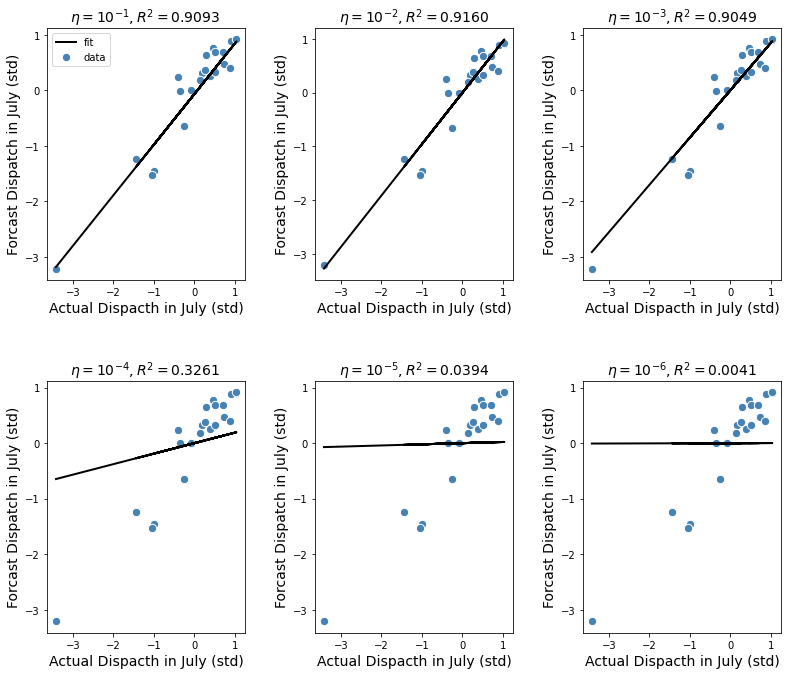

In [40]:
np.set_printoptions(precision=1)
# plot with various axes scales
plt.figure(figsize=(12,10))

# fig 1
plt.subplot(231)
plt.scatter(X,y1,c='steelblue', edgecolor='white', s=70,label='data')
plt.plot(X, GradientDescent(eta=0.1, n_iter=100).fit(X,y1).predict(X),color='black', lw=2,label='fit')
plt.title('$\eta = 10^{-1}, R^2 = 0.9093$ ',size=14)
plt.grid(False)
plt.xlabel('Actual Dispacth in July (std)',size=14)
plt.ylabel('Forcast Dispatch in July (std)',size=14)
plt.legend()

# fig 2
plt.subplot(232)
plt.scatter(X,y1,c='steelblue', edgecolor='white', s=70)
plt.plot(X, GradientDescent(eta=0.01, n_iter=100).fit(X,y1).predict(X),color='black', lw=2)
plt.title('$\eta = 10^{-2},R^2 =  0.9160$',size=14)
plt.grid(False)
plt.xlabel('Actual Dispacth in July (std)',size=14)
plt.ylabel('Forcast Dispatch in July (std)',size=14)


# fig 3
plt.subplot(233)
plt.scatter(X,y1,c='steelblue', edgecolor='white', s=70)
plt.plot(X,GradientDescent(eta=0.001, n_iter=100).fit(X,y1).predict(X),color='black', lw=2)
plt.title('$\eta =10^{-3},R^2 = 0.9049$',size=14)
plt.grid(False)
plt.xlabel('Actual Dispacth in July (std)',size=14)
plt.ylabel('Forcast Dispatch in July (std)',size=14)


# fig 4
plt.subplot(234)
plt.scatter(X,y1,c='steelblue', edgecolor='white', s=70)
plt.plot(X, GradientDescent(eta=0.0001, n_iter=100).fit(X,y1).predict(X),color='black', lw=2)
plt.title('$\eta = 10^{-4}, R^2 = 0.3261$ ',size=14)
plt.grid(False)
plt.xlabel('Actual Dispacth in July (std)',size=14)
plt.ylabel('Forcast Dispatch in July (std)',size=14)


# fig 5
plt.subplot(235)
plt.scatter(X,y1,c='steelblue', edgecolor='white', s=70)
plt.plot(X, GradientDescent(eta=0.00001, n_iter=100).fit(X,y1).predict(X),color='black', lw=2)
plt.title('$\eta = 10^{-5},R^2 = 0.0394$',size=14)
plt.grid(False)
plt.xlabel('Actual Dispacth in July (std)',size=14)
plt.ylabel('Forcast Dispatch in July (std)',size=14)


# fig 6
plt.subplot(236)
plt.scatter(X,y1,c='steelblue', edgecolor='white', s=70)
plt.plot(X,GradientDescent(eta=0.000001, n_iter=100).fit(X,y1).predict(X),color='black', lw=2)
plt.title('$\eta =10^{-6},R^2 = 0.0041$',size=14)
plt.grid(False)
plt.xlabel('Actual Dispacth in July (std)',size=14)
plt.ylabel('Forcast Dispatch in July (std)',size=14)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
#plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.35)

plt.show()